<a href="https://colab.research.google.com/github/garg-saurav/DeepNAT-2D/blob/master/DeepNAT_2D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
# install required packages
!pip install nilearn
!pip install deepbrain
!pip install pydensecrf

In [2]:
# imports
import os
import numpy as np
import nibabel as nib
from nilearn import plotting
import matplotlib.pyplot as plt
from skimage import data
import scipy
import time
import random, math
import pickle
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_softmax, create_pairwise_bilateral
from scipy.sparse.linalg import eigs
import pandas as pd

In [3]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras

In [4]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [5]:
%cd /gdrive/My\ Drive/DeepNAT-2D
nib.Nifti1Header.quaternion_threshold = -1e-06

/gdrive/My Drive/DeepNAT-2D


# **Dataset Generation** #

In [6]:
# x_train = []
# y_train = []
# directory = r'./MICCAI-2012-Multi-Atlas-Challenge-Data/training-images'
# directory_1 = r'./MICCAI-2012-Multi-Atlas-Challenge-Data/training-images'
# directory2 = r'./MICCAI-2012-Multi-Atlas-Challenge-Data/training-labels'
# directory2_1 = r'./MICCAI-2012-Multi-Atlas-Challenge-Data/training-labels'
# for filename in os.listdir(directory):
#     if filename.endswith(".gz"):
#         x_train.append(np.array(nib.load(os.path.join(directory, filename)).get_fdata()[:,:,112]))
#         label = np.array(nib.load(os.path.join(directory2, str(filename)[:-7]+"_glm.nii.gz")).get_fdata()[:,:,112])
#         temp_y = np.zeros_like(label)
#         temp_y[label>0]=1.0
#         y_train.append(temp_y)
#     else:
#         continue
# x_train = np.array(x_train)
# y_train = np.array(y_train)

In [7]:
# x_test = []
# y_test = []
# directory = r'./MICCAI-2012-Multi-Atlas-Challenge-Data/testing-images'
# directory2 = r'./MICCAI-2012-Multi-Atlas-Challenge-Data/testing-labels'
# for filename in os.listdir(directory):
#     if filename.endswith(".gz"):
#         x_test.append(np.array(nib.load(os.path.join(directory, filename)).get_fdata()[:,:,112]))
#         label = np.array(nib.load(os.path.join(directory2, str(filename)[:-7]+"_glm.nii.gz")).get_fdata()[:,:,112])
#         temp_y = np.zeros_like(label)
#         temp_y[label>0]=1.0
#         y_test.append(temp_y)
#     else:
#         continue
# x_test = np.array(x_test)
# y_test = np.array(y_test)

In [8]:
def center_data(data, x1=None, x2=None, y1=None, y2=None):
  if x1 is None:
    nzi = np.nonzero(data) # non zero indices
    x1,x2,y1,y2=min(nzi[0]),max(nzi[0]),min(nzi[1]),max(nzi[1])
    new_data = np.zeros_like(data)
    x3, y3 = (x2-x1)/2, (y2-y1)/2
    xc, yc = data.shape[0]//2, data.shape[1]//2
    xc1, xc2, yc1, yc2 = math.ceil(xc-x3), math.ceil(xc+x3), math.ceil(yc-y3), math.ceil(yc+y3)
    new_data[xc1:xc2+1,yc1:yc2+1]=data[x1:x2+1,y1:y2+1]
    return (new_data, x1, x2, y1, y2)
  else:
    new_data = np.zeros_like(data)
    xc, yc = data.shape[0]//2, data.shape[1]//2
    x3, y3 = (x2-x1)/2, (y2-y1)/2
    xc1, xc2, yc1, yc2 = math.ceil(xc-x3), math.ceil(xc+x3), math.ceil(yc-y3), math.ceil(yc+y3)
    new_data[xc1:xc2+1,yc1:yc2+1]=data[x1:x2+1,y1:y2+1]
    return (new_data, x1, x2, y1, y2)


In [9]:
# x_train_centered = []
# y_train_centered = []
# directory = r'./dataset/training-images-centered'
# directory_1 = r'./dataset/training-labels-centered'
# for i in range(len(x_train)):
#     temp_data = center_data(x_train[i])
#     x_train_centered.append(temp_data[0])
#     temp_data_1 = center_data(y_train[i], temp_data[1], temp_data[2], temp_data[3], temp_data[4])
#     y_train_centered.append(temp_data_1[0])
# x_train_centered = np.array(x_train_centered)
# y_train_centered = np.array(y_train_centered)

In [10]:
# x_test_centered = []
# y_test_centered = []
# directory = r'./dataset/testing-images-centered'
# directory_1 = r'./dataset/testing-labels-centered'
# for i in range(len(x_test)):
#     temp_data = center_data(x_test[i])
#     x_test_centered.append(temp_data[0])
#     temp_data_1 = center_data(y_test[i], temp_data[1], temp_data[2], temp_data[3], temp_data[4])
#     y_test_centered.append(temp_data_1[0])
# x_test_centered = np.array(x_test_centered)
# y_test_centered = np.array(y_test_centered)

In [11]:
# np.save(r'./dataset/testing-images-centered/x_test.npy', x_test_centered, allow_pickle = False)
# np.save(r'./dataset/testing-labels-centered/y_test.npy', y_test_centered, allow_pickle = False)

#**Loading the Data**#

In [12]:
x_train = np.load('./dataset/training-images-centered/x_train.npy')
y_train = np.load('./dataset/training-labels-centered/y_train.npy')
x_test = np.load('./dataset/testing-images-centered/x_test.npy')
y_test = np.load('./dataset/testing-labels-centered/y_test.npy')

#**Exploratory Data Analysis**#

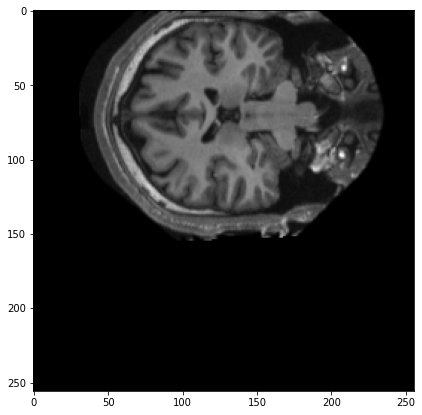

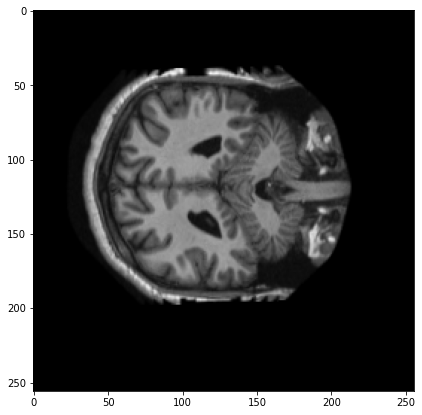

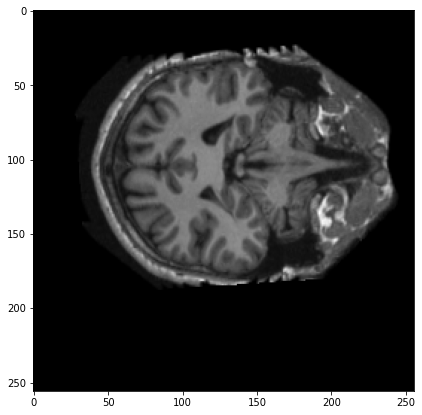

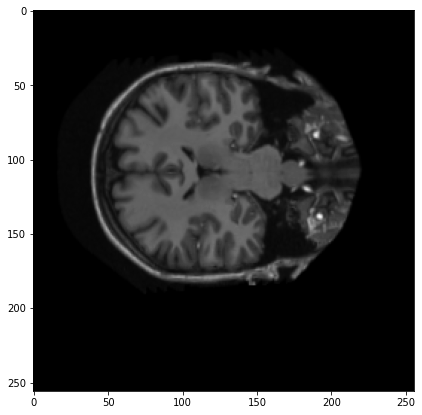

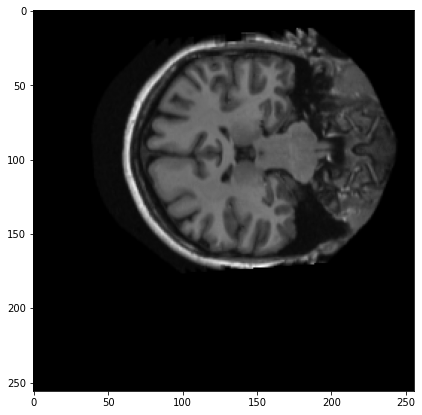

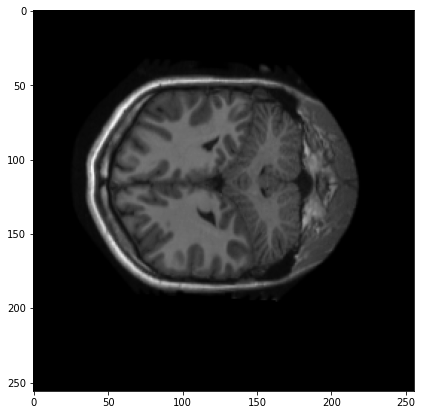

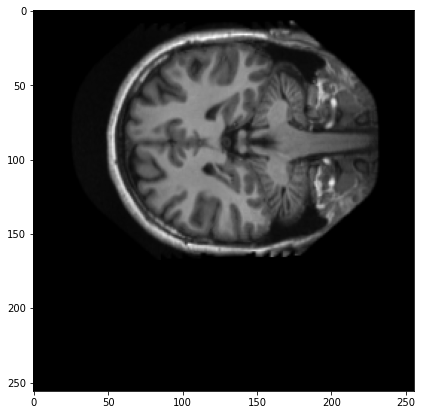

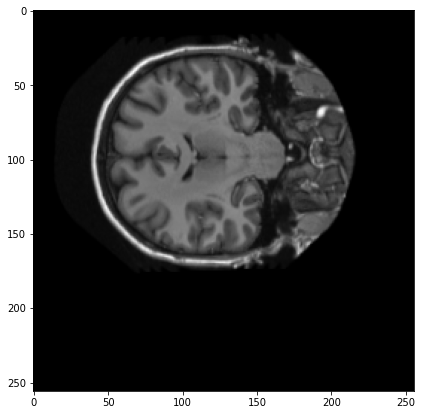

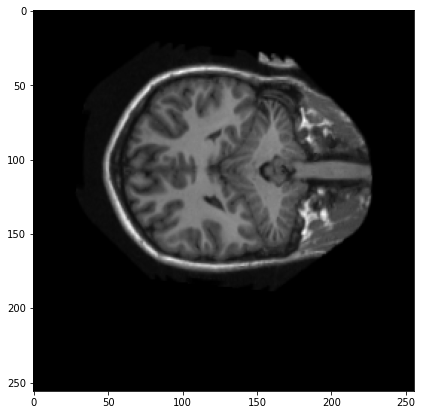

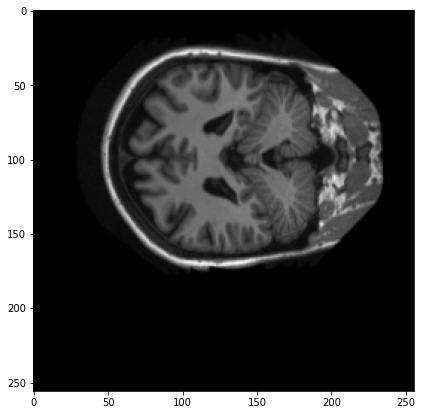

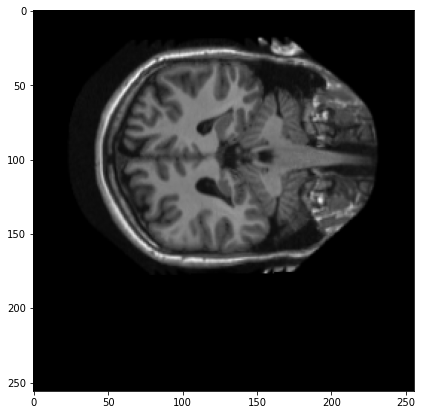

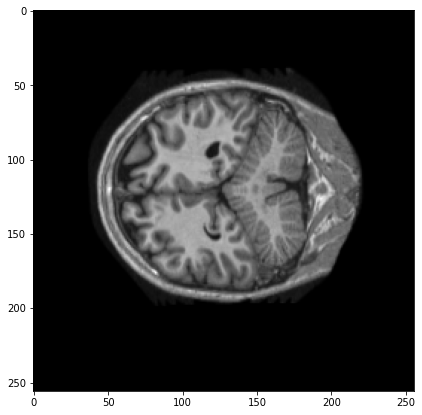

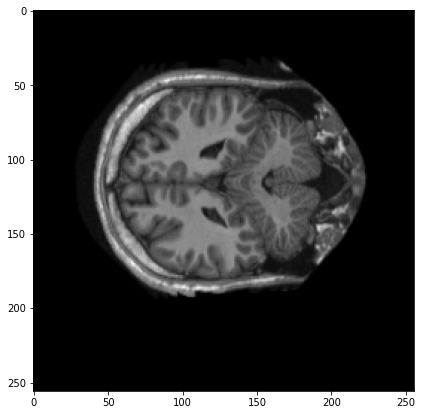

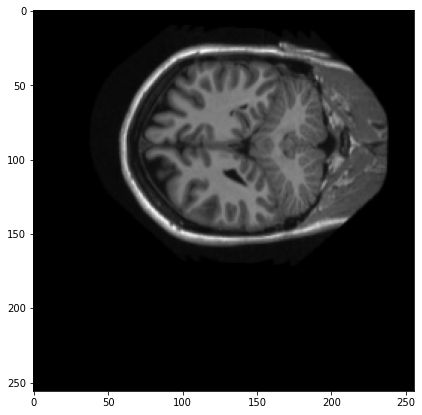

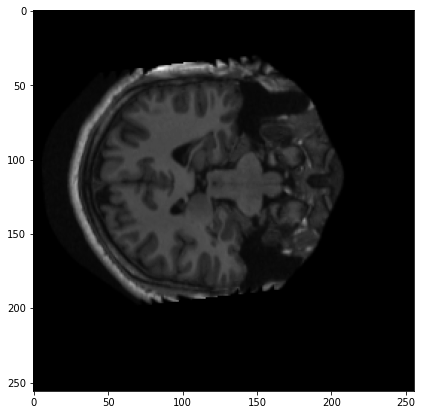

In [13]:
directory = r'./MICCAI-2012-Multi-Atlas-Challenge-Data/training-images'
for filename in os.listdir(directory):
    if filename.endswith(".gz"):
        img_data = nib.load(os.path.join(directory,filename)).get_fdata().copy()
        image = np.array(img_data)[:,:,112]
        fig, axs = plt.subplots(figsize=(7,7))
        axs.imshow(image,cmap='gray')
    else:
        continue

(256, 256)


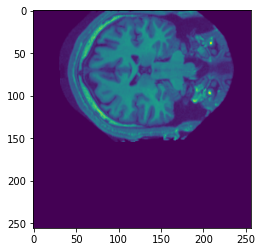

In [14]:
train_img_data = (np.load('./dataset/training-images/x_train.npy'))[0]
print(train_img_data.shape)
plt.imshow(train_img_data)

In [15]:
train_label_data = np.load('./dataset/training-labels/y_train.npy')[0]
print(train_label_data.shape)

(256, 256)


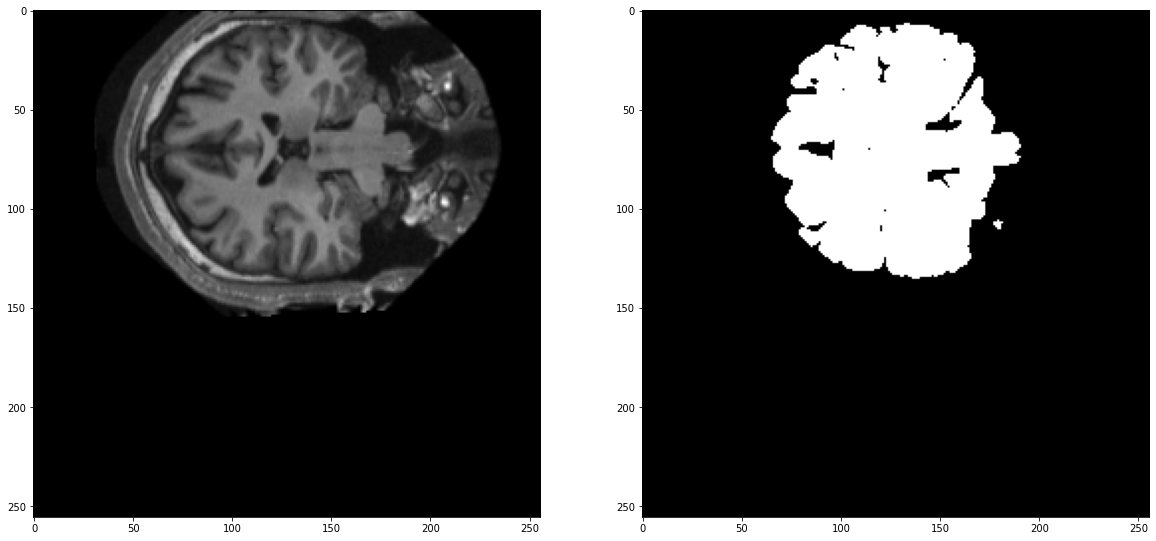

In [16]:
img_no=180
fig, axs = plt.subplots(1, 2, figsize=(20,20)) 
axs[0].imshow(train_img_data,cmap='gray')
axs[1].imshow(train_label_data,cmap='gray')
plt.show() 

In [17]:
from matplotlib.colors import colorConverter
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

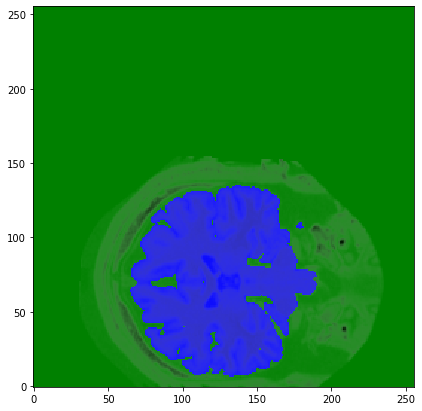

In [18]:
# overlapping images

zvals = train_label_data
zvals2 = train_img_data

# generate the colors for your colormap
color1 = colorConverter.to_rgba('white')
color2 = colorConverter.to_rgba('black')

# make the colormaps
cmap1 = mpl.colors.LinearSegmentedColormap.from_list('my_cmap',['green','blue'],256)
cmap2 = mpl.colors.LinearSegmentedColormap.from_list('my_cmap2',[color1,color2],256)

cmap2._init() # create the _lut array, with rgba values

# create your alpha array and fill the colormap with them.
# here it is progressive, but you can create whathever you want
alphas = np.linspace(0, 0.8, cmap2.N+3)
cmap2._lut[:,-1] = alphas

fig, axs = plt.subplots(figsize=(7,7)) 
img2 = axs.imshow(zvals, interpolation='nearest', cmap=cmap1, origin='lower')
img3 = axs.imshow(zvals2, interpolation='nearest', cmap=cmap2, origin='lower')

plt.show()


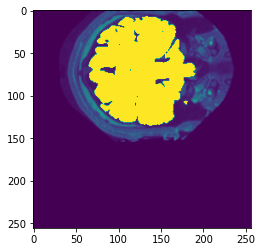

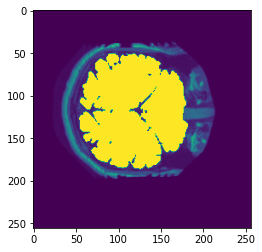

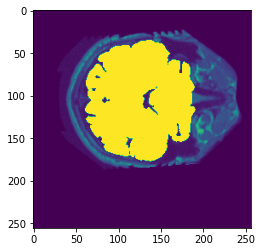

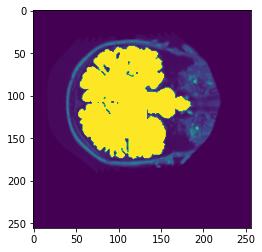

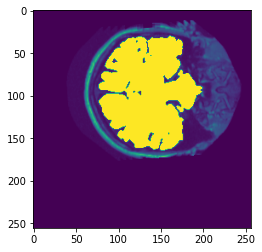

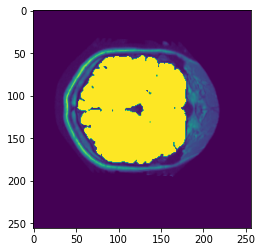

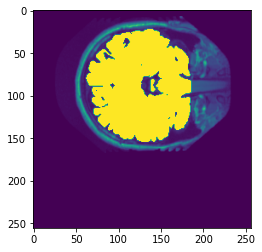

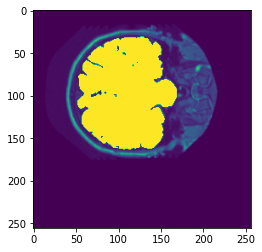

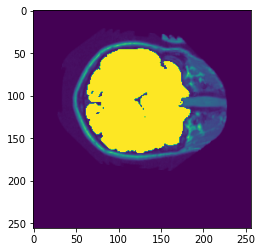

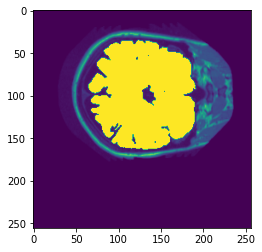

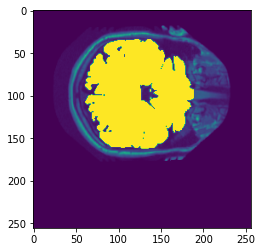

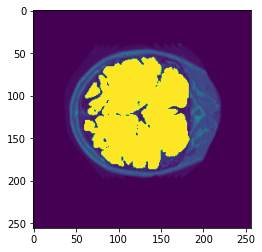

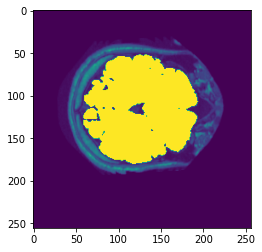

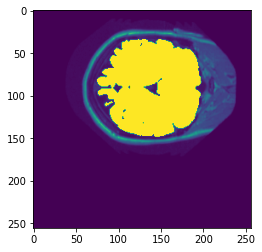

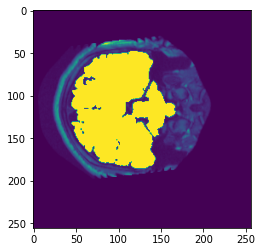

In [19]:
for i in range(len(x_train)):
  temp = x_train[i].copy()
  temp[y_train[i]>0]=4096
  plt.figure()
  plt.imshow(temp)

#**Spectral Coordinates**#

In [20]:
def convert(x, y, shape):
  return (x * shape[1] + y)

def getLaplacian(img_data):
  shape = img_data.shape
  dim = shape[0] * shape[1]
  A = scipy.sparse.lil_matrix((dim, dim))
  D = scipy.sparse.lil_matrix((dim, dim))
  dx = [-1, 0, 0, 1]
  dy = [0, 1, -1, 0]
  row_A = []
  col_A = []
  row_L = []
  data_L = []
  for i in range(shape[0]):
    for j in range(shape[1]):
      coord = convert(i, j, shape)
      num = 0
      for k in range(4):
        nx = i + dx[k]
        ny = j + dy[k]
        if(nx >= 0 and ny >= 0 and nx < shape[0] and ny < shape[1] and img_data[i, j] > 0 and img_data[nx, ny] > 0):
            row_A.append(coord)          
            col_A.append(convert(nx, ny, shape))
            num+=1
      row_L.append(coord)
      data_L.append(num)
  A = scipy.sparse.coo_matrix((np.ones_like(row_A), (row_A,col_A)), shape=(dim,dim)).asfptype()
  D = scipy.sparse.coo_matrix((data_L, (row_L,row_L)), shape=(dim,dim)).asfptype()
  L = A - D
  return L

In [21]:
# spectralCoordinates = []
# for img_data in x_train:
#   print(num)
#   L = getLaplacian(img_data)
#   vals, vecs = scipy.sparse.linalg.eigsh(L, 3, sigma=1e-16, which='LM',mode='cayley')
#   spectralCoordinates.append(np.array(vecs[:,1:3]))

# with open('./dataset/spectral-coordinates/training-coords/spectral_coordinates_x_train.npy', 'wb') as f:
#     np.save(f, np.array(spectralCoordinates))

In [22]:
# spectralCoordinates = []
# for img_data in x_test:
#   L = getLaplacian(img_data)
#   vals, vecs = scipy.sparse.linalg.eigsh(L, 3, sigma=1e-16, which='LM',mode='cayley')
#   spectralCoordinates.append(np.array(vecs[:,1:3]))

# with open('./dataset/spectral-coordinates/testing-coords/spectral_coordinates_x_test.npy', 'wb') as f:
#     np.save(f, np.array(spectralCoordinates))

In [23]:
spectral_coordinates_x_train = np.load('./dataset/spectral-coordinates/training-coords/spectral_coordinates_x_train.npy')
spectral_coordinates_x_test = np.load('./dataset/spectral-coordinates/testing-coords/spectral_coordinates_x_test.npy')
print(spectral_coordinates_x_train.shape)
print(spectral_coordinates_x_test.shape)

(15, 65536, 2)
(20, 65536, 2)


#**Data Pipeline**#

In [24]:
output_names = {1:"center", 2:"top", 3:"bottom", 4:"left", 5:"right"}

In [25]:
# generator for generationg training patches
def gen():
  while True:
    rand_ind = random.randint(1,len(x_train))
    imgno = rand_ind-1
    train_img_data = x_train[imgno]
    train_label_data = y_train[imgno]
    patch_size = 23
    dist_center = (patch_size - 1) // 2
    xi, yi = train_img_data.shape
    xc = random.randint(dist_center, xi - dist_center-1)
    yc = random.randint(dist_center, yi - dist_center-1)
    xl, yl= (xc - dist_center, yc - dist_center)
    xr, yr= (xc + dist_center, yc + dist_center)
    X1 = train_img_data[xl:(xr + 1), yl:(yr + 1)]
    dx = [0, 0, 0, -1, 1]
    dy = [0, 1, -1, 0, 0]
    Y = {} # [center, top, bottom, left, right]
    for i in range(5):
      Y[output_names[i+1]]=np.array([int(train_label_data[xc + dx[i]][yc + dy[i]] > 0), int(train_label_data[xc + dx[i]][yc + dy[i]] <= 0)])
    cartesianCoordinate = np.array([xc, yc])
    coord = convert(xc, yc, train_img_data.shape)
    spectralCoordinates = np.array([spectral_coordinates_x_train[imgno][coord][0], spectral_coordinates_x_train[imgno][coord][1]])
    X2 = np.concatenate((cartesianCoordinate, spectralCoordinates)).reshape((4,1))
    X = {} # [image, coords]
    X["image"] = X1/4096.0
    X["coords"] = X2
    yield (X, Y)

In [26]:
# batch size and number of epochs
BS = 512 
num_epochs = 15

In [27]:
dataset = tf.data.Dataset.from_generator(gen, ({"image": tf.float32, "coords": tf.float32}, {k: tf.float32 for k in output_names.values()}), output_shapes=({"image":tf.TensorShape([23,23]), "coords":tf.TensorShape([4,1])}, {k: tf.TensorShape([2,]) for k in output_names.values()}))
dataset = dataset.batch(BS)
dataset.element_spec

({'coords': TensorSpec(shape=(None, 4, 1), dtype=tf.float32, name=None),
  'image': TensorSpec(shape=(None, 23, 23), dtype=tf.float32, name=None)},
 {'bottom': TensorSpec(shape=(None, 2), dtype=tf.float32, name=None),
  'center': TensorSpec(shape=(None, 2), dtype=tf.float32, name=None),
  'left': TensorSpec(shape=(None, 2), dtype=tf.float32, name=None),
  'right': TensorSpec(shape=(None, 2), dtype=tf.float32, name=None),
  'top': TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)})

In [28]:
# tic = time.time()
# for i in dataset:
#   print(i)
#   break
# toc = time.time()
# print(toc-tic)

#**Build DCNN Model**#

In [29]:
# imports
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D, Dropout, Input, ZeroPadding2D, BatchNormalization, ReLU, Concatenate, Softmax
from tensorflow.keras import Model, backend as K
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score

assert(tf.__version__.startswith("2."))

In [30]:
def build_model(tasks):
  # tasks is the number of pixels in the neighbourhood
  # we have used a five neighbourhood system (including the center pixel)
  img_input = Input(shape=(23, 23, 1), name="image")
  coords_input = Input(shape=(4), name="coords") # first two cartesian then spectral
  x = Conv2D(filters=32, kernel_size=7, activation='relu', kernel_initializer='GlorotUniform',bias_initializer='GlorotUniform')(img_input)
  x = ZeroPadding2D(padding=((0, 1), (0, 1)))(x) # padding to mimic caffe behaviour
  x = MaxPool2D(pool_size=(2,2),strides=(2,2))(x)
  x = Conv2D(filters=64, kernel_size=5, kernel_initializer='GlorotUniform',bias_initializer='GlorotUniform')(x)
  x = BatchNormalization(axis=-1,scale=False)(x)
  x = ReLU()(x)
  x = Conv2D(filters=64, kernel_size=3, kernel_initializer='GlorotUniform',bias_initializer='GlorotUniform')(x)
  x = BatchNormalization(axis=-1,scale=False)(x)
  x = ReLU()(x)
  x = Flatten()(x)
  x = Dense(units=1024, activation='relu')(x)
  x = Dropout(rate=0.5)(x)
  x = Concatenate(axis=1)([x,coords_input])
  x = Dense(units=512)(x)
  x = BatchNormalization(axis=-1,scale=False)(x)
  x = ReLU()(x)
  x = Dropout(rate=0.5)(x)
  outputs=[]
  for i in range(1,tasks+1):
    if(tasks==5):
      temp = Dense(units=2)(x)
      outputs.append(Softmax(name=output_names[i])(temp))
    else:
      outputs.append(Dense(units=2)(x))
  return Model(inputs=[img_input, coords_input], outputs=outputs)


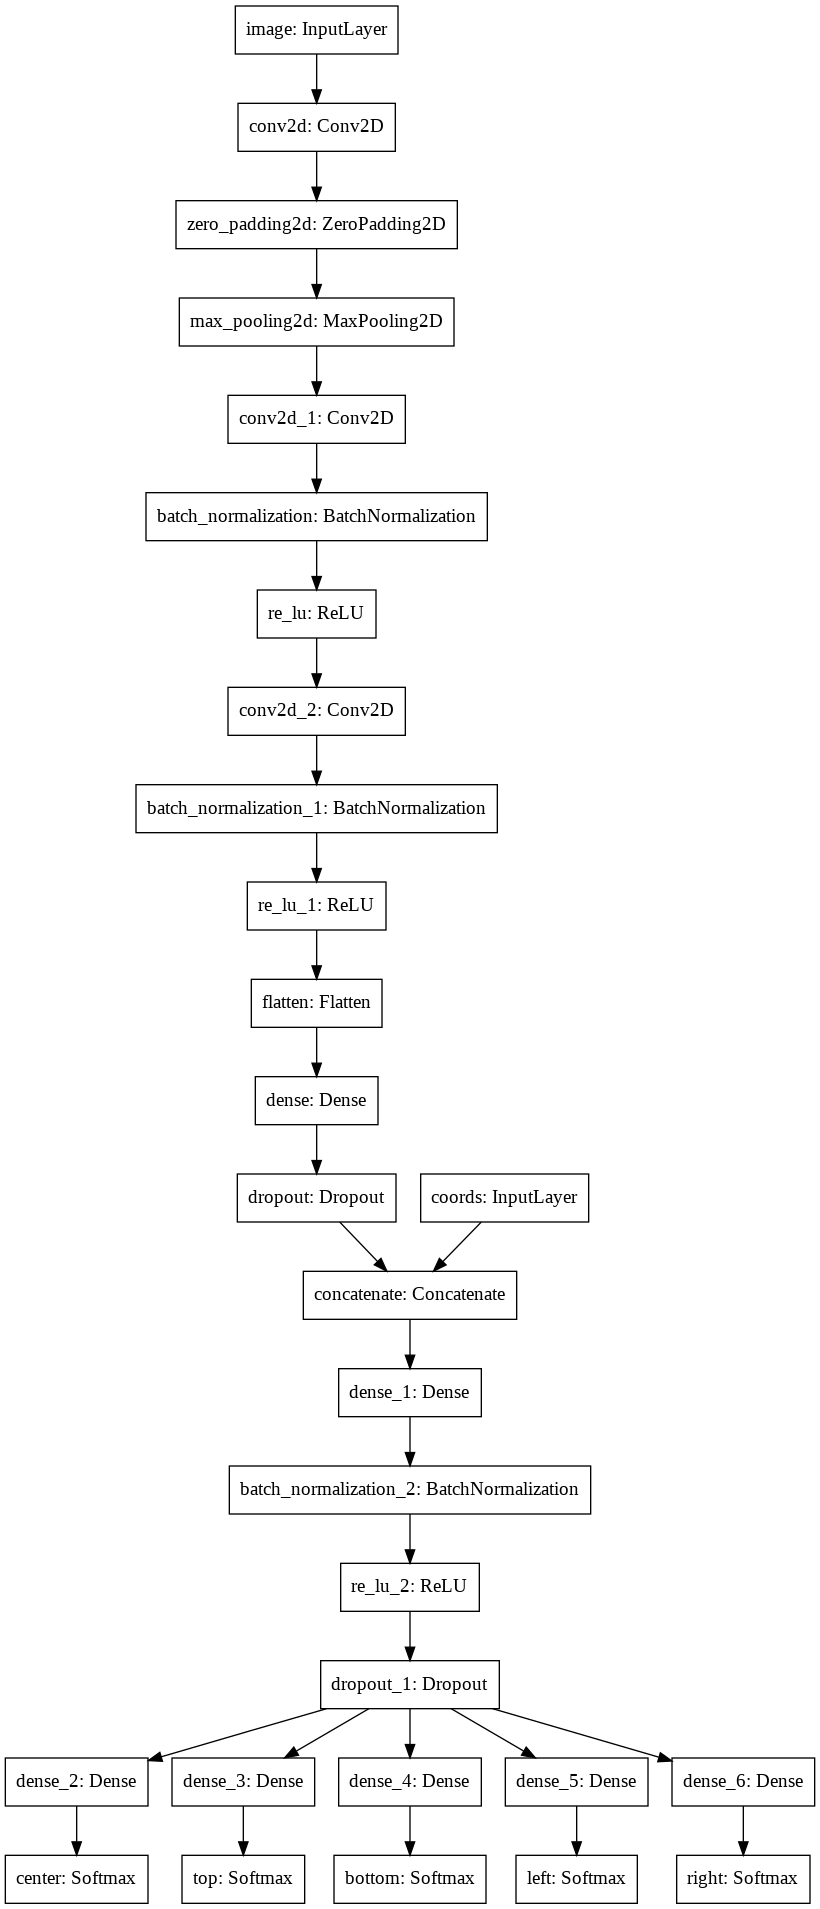

In [31]:
model = build_model(5)
model._layers = [layer for layer in model._layers if not isinstance(layer, dict)]
tf.keras.utils.plot_model(model, to_file="model.png")

In [32]:
model.summary()
with open('model_architecture.txt','w') as fh:
    # Pass the file handle in as a lambda function to make it callable
    model.summary(print_fn=lambda x: fh.write(x + '\n'))

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 23, 23, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 17, 17, 32)   1600        image[0][0]                      
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 18, 18, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 9, 9, 32)     0           zero_padding2d[0][0]             
______________________________________________________________________________________________

In [33]:
# UNCOMMENT AND RUN THIS CELL TO RETRAIN THE MODEL 
# WE HAVE ALREADY STORED THE TRAINED MODEL YOU CAN JUST LOAD IT IN NEXT CELL

# checkpoint_filepath = r"./checkpoint/weights.{epoch:02d}.hdf5"
# model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=False)

# model = build_model(5)

# losses = {}
# for output_name in output_names.values():
#  losses[output_name] = "categorical_crossentropy"

# model.compile(optimizer='adam', loss=losses, metrics=['accuracy'])

# history = model.fit(dataset, steps_per_epoch=BS, epochs=num_epochs, verbose=1,  callbacks=[model_checkpoint_callback], shuffle=False)

# with open(r'./model-history/hist_run2_BS_{}_Epochs_{}_with_spectral'.format(BS, num_epochs), 'wb') as file_pi:
#   pickle.dump(history.history, file_pi)

# model.save('model_run2_BS_{}_Epochs_{}_with_spectral'.format(BS, num_epochs))

In [34]:
history = pickle.load(open('./model-history/hist_run2_BS_512_Epochs_15_with_spectral', "rb"))

model = keras.models.load_model('model_run2_BS_512_Epochs_15_with_spectral')

#**Fully Connected CRF**#

In [35]:
def dense_crf(img_data, output_probas, sigma_alpha, sigma_beta, sigma_gamma, w1, w2=1):

    img_data = img_data.reshape((256, 256, 1))
    W, H, NLABELS = 256, 256, 2

    unary = output_probas
    unary[unary == 0] = 1e-10
    U = -np.log(unary)
    U = U.transpose((2, 0, 1))
    U = U.reshape((2, -1))
    U = U.copy(order = 'C')
    U = U.astype(np.float32).copy()

    d = dcrf.DenseCRF2D(W, H, NLABELS)
    d.setUnaryEnergy(U)
    pairwise_energy = create_pairwise_bilateral(sdims=(sigma_alpha, sigma_alpha), schan=(sigma_beta,), img = img_data, chdim=2)
    d.addPairwiseEnergy(pairwise_energy, compat = w1)
    d.addPairwiseGaussian(sxy = sigma_gamma, compat = w2)
    Q = d.inference(100)
    map = np.argmax(Q, axis=0).reshape((256, 256))
    return 1-map

In [36]:
# Dice volume overlap score
def dice(y_data, pred_data):
  return (2.0*np.sum(y_data==pred_data))/(np.sum(np.ones_like(y_data))+np.sum(np.ones_like(pred_data)))

In [37]:
# FOUND USING GRID SEARCH
(sigma_alpha, sigma_beta, sigma_gamma, w1) = (10, 0.01, 1, 10)

#**Prediction**#

In [38]:
# generator to generate patches from testing image
def gen_predict(img_data, spectral):
  patch_size = 23
  dist_center = (patch_size - 1) // 2
  l, b = img_data.shape
  for yc in range(dist_center, b - dist_center):
    for xc in range(dist_center, l - dist_center):    
      xl, yl = (xc - dist_center, yc - dist_center)
      xr, yr = (xc + dist_center, yc + dist_center)
      cartesianCoordinates = np.array([xc, yc])
      coord = convert(xc, yc, img_data.shape)
      spectralCoordinates = np.array([spectral[coord][0], spectral[coord][1]])
      X = {"image": (img_data[xl:(xr + 1), yl:(yr + 1)])/4096.0, "coords":np.concatenate((cartesianCoordinates, spectralCoordinates)).reshape((4,1))}
      yield (X,)

In [39]:
# return binary prediction using the probabilities 
# True: foreground pixel
# False: Background pixel
def get_predictions(probas):
  pred = np.full((256,256),False)
  for i in range(256):
    for j in range(256):
      if(probas[i,j,0]>probas[i,j,1]):
        pred[i,j] = True
  return pred

In [40]:
# return probabilities from the model output
# averages the results from different patches for same pixel
# works as an ensemble
def get_probas(model_output):
  num_patches = model_output.shape[1]
  temp_probas = np.zeros((256,256,3)) # [proba_fore_agg, proba_back_agg, num_points]
  for i in range(num_patches): # [proba_fore_agg/num, proba_back_agg/num]
    xc, yc =  11+(i%234) ,11+(i//234)
    dx = [0, 0, 0, -1, 1]
    dy = [0, 1, -1, 0, 0]
    for k in range(5):
      temp = temp_probas[xc + dx[k]][yc + dy[k]]
      temp[2] += 1
      temp[0], temp[1] = temp[0] + model_output[k][i][0], temp[1] + model_output[k][i][1]
      temp_probas[xc + dx[k]][yc + dy[k]]=temp
  probas = np.zeros((256,256,2)) # [probability_foreground, probability_background]
  probas[11:245,11:245] = temp_probas[11:245,11:245,0:2]/temp_probas[11:245,11:245,2].reshape(234,234,1) # border not predicted
  return probas

In [41]:
# calls the model.predict function to get model_output
def predict_probas(img_data, spectral):
    temp_gen = gen_predict(img_data, spectral)
    dataset_pred = tf.data.Dataset.from_generator(lambda: temp_gen, ({"image":tf.float32, "coords":tf.float32},), output_shapes=({"image":tf.TensorShape([23,23]), "coords":tf.TensorShape([4,1])},))
    dataset_pred = dataset_pred.batch(1024)
    model_output = np.array(model.predict(dataset_pred, verbose=1)) # [5, ?, 2]
    probas = get_probas(model_output) # [256, 256, 2]
    return probas

In [42]:
# sample prediction call
img_data, spectral = x_test[12,:,:], spectral_coordinates_x_test[12] 
final_pred_probas = predict_probas(img_data, spectral)
final_pred_sample = get_predictions(final_pred_probas)

54/54 [==============================] - 15s 286ms/step


In [43]:
final_pred_sample_crf = final_pred_sample.copy()
final_pred_sample_crf= dense_crf(np.array(x_test[12,:,:]), final_pred_probas,sigma_alpha,sigma_beta,sigma_gamma,w1)

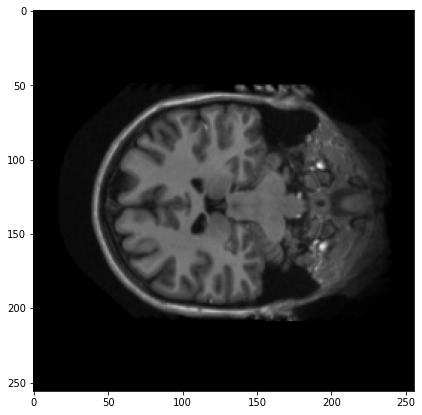

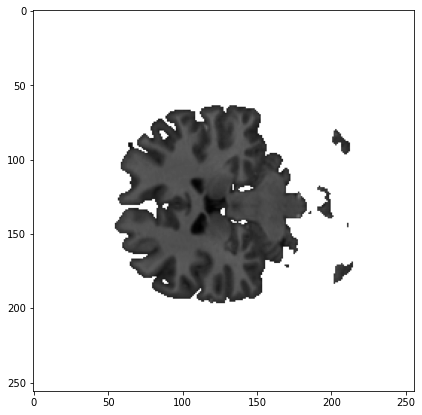

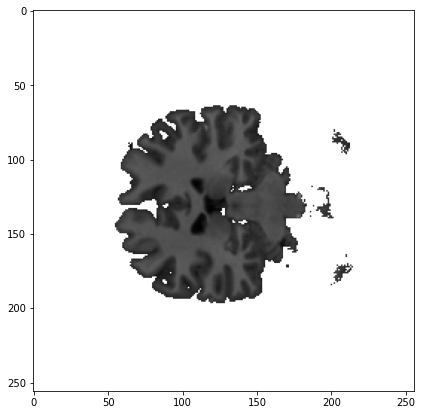

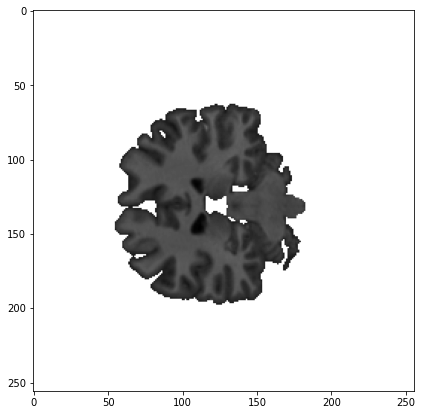

In [44]:
# visualize the sample prediction

img_data = x_test[12,:,:].copy()
label_img_data = y_test[12,:,:].copy()
fig, axs = plt.subplots(figsize=(7,7))
axs.imshow(img_data,cmap='gray') # the input image

img_data = x_test[12,:,:].copy()
img_data[final_pred_sample==False] = 4096.0
fig, axs = plt.subplots(figsize=(7,7)) # visualize the predicted foreground without crf

axs.imshow(img_data,cmap='gray')
img_data = x_test[12,:,:].copy()
img_data[final_pred_sample_crf==0] = 4096.0
fig, axs = plt.subplots(figsize=(7,7)) 
axs.imshow(img_data,cmap='gray') # visualize the predicted foreground with crf

img_data = x_test[12,:,:].copy()
img_data[label_img_data==0] = 4096.0
fig, axs = plt.subplots(figsize=(7,7))
axs.imshow(img_data,cmap='gray') # ground truth

#**Results**#

In [45]:
# dice_without_crf = []
# dice_no_coordinates = []
# dice_with_crf = []
# dice_only_spectral = []
# dice_only_cartesian = []
# predictions_with_crf = []
# predictions_without_crf = []
# for i in range(len(x_test)):
#     img_data = x_test[i,:,:]
#     spectral = spectral_coordinates_x_test[i]
#     final_pred_probas = predict_probas(img_data, spectral)
#     final_pred_sample = get_predictions(final_pred_probas)
#     final_pred_sample_crf = final_pred_sample.copy()
#     final_pred_sample_crf= dense_crf(np.array(x_test[i,:,:]), final_pred_probas,10,0.01,1,10)
#     predictions_with_crf.append(final_pred_sample)
#     predictions_without_crf.append(final_pred_sample_crf)
#     dice_without_crf.append(dice(y_test[i,:,:], final_pred_sample))
#     dice_with_crf.append(dice(y_test[i,:,:], final_pred_sample_crf))

In [46]:
# with open('./results/predictions_with_crf.npy', 'wb') as f:
#     np.save(f, np.array(predictions_with_crf))
# with open('./results/predictions_without_crf.npy', 'wb') as f:
#     np.save(f, np.array(predictions_without_crf))
# with open('./results/dice_with_crf.npy', 'wb') as f:
#     np.save(f, np.array(dice_with_crf))
# with open('./results/dice_without_crf.npy', 'wb') as f:
#     np.save(f, np.array(dice_without_crf))
# with open('./results/dice_only_cartesian.npy', 'wb') as f:
#     np.save(f, np.array(dice_only_cartesian))
# with open('./results/dice_no_coordinates.npy', 'wb') as f:
#     np.save(f, np.array(dice_no_coordinates))
# with open('./results/dice_only_spectral.npy', 'wb') as f:
#     np.save(f, np.array(dice_only_spectral))
dice_with_crf = np.load('./results/dice_with_crf.npy')
dice_without_crf = np.load('./results/dice_without_crf.npy')
dice_only_spectral = np.load('./results/dice_only_spectral.npy')
dice_only_cartesian = np.load('./results/dice_only_cartesian.npy')
dice_no_coordinates = np.load('./results/dice_no_coordinates.npy')

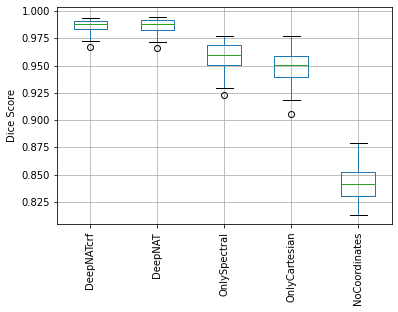

In [47]:
df = pd.DataFrame(list(zip(dice_with_crf, dice_without_crf, dice_only_spectral, dice_only_cartesian, dice_no_coordinates)), columns=['DeepNATcrf', 'DeepNAT', 'OnlySpectral', 'OnlyCartesian', 'NoCoordinates'])
boxplot = df.boxplot(column=['DeepNATcrf', 'DeepNAT', 'OnlySpectral', 'OnlyCartesian', 'NoCoordinates'], rot=90)
plt.ylabel("Dice Score")

In [48]:
df.median()

DeepNATcrf       0.988060
DeepNAT          0.988518
OnlySpectral     0.959846
OnlyCartesian    0.950699
NoCoordinates    0.841072
dtype: float64

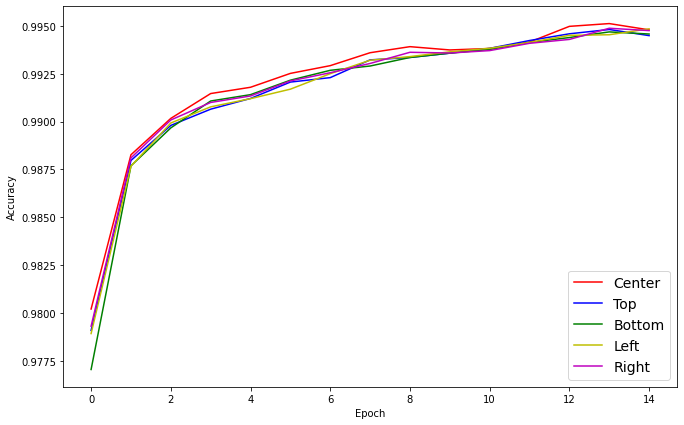

In [49]:
# plot accuracy vs epochs
plt.figure(figsize=(11,7))
plt.plot(history['center_accuracy'], 'r')
plt.plot(history['top_accuracy'], 'b')
plt.plot(history['bottom_accuracy'], 'g')
plt.plot(history['left_accuracy'], 'y')
plt.plot(history['right_accuracy'], 'm')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Center','Top','Bottom','Left','Right'],loc="lower right", prop={'size': 14})
plt.show()

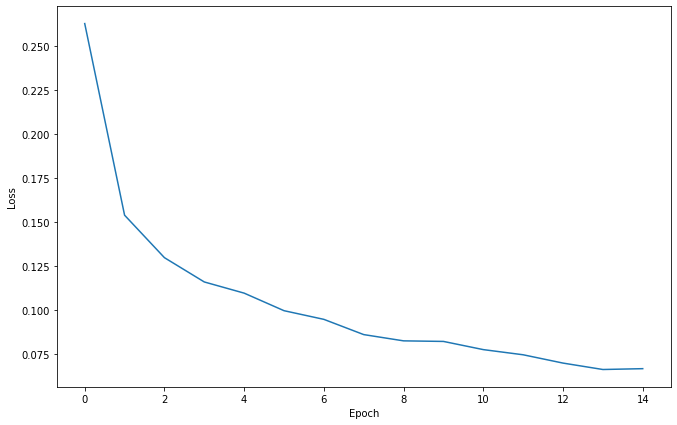

In [50]:
# plot loss vs epochs
plt.figure(figsize=(11,7))
plt.plot(history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

#**References**#

####*Wachinger C, Reuter M, Klein T. DeepNAT: Deep convolutional neural network for segmenting neuroanatomy. Neuroimage. 2018;170:434‐445. doi:10.1016/j.neuroimage.2017.02.035*####

####*Efficient Inference in Fully Connected CRFs with Gaussian Edge Potentials*####
####*Philipp Krähenbühl and Vladlen Koltun*####
####*NIPS 2011*####
####*https://github.com/lucasb-eyer/pydensecrf*####

####*https://stackoverflow.com/questions/10127284/overlay-imshow-plots-in-matplotlib*####

####*https://www.newbedev.com/python/howto/how-to-iterate-over-files-in-a-given-directory/*####

####*The data used was provided for use in the MICCAI 2012 Grand Challenge and Workshop on Multi-Atlas Labeling [B. Landman, S. Warfield, MICCAI 2012 workshop on multi-atlas labeling, in: MICCAI Grand Challenge and Workshop on Multi-Atlas Labeling, CreateSpace Independent Publishing Platform, Nice, France, 2012.].  The data is released under the Creative Commons Attribution-NonCommercial license (CC BY-NC) with no end date.  Original MRI scans are from OASIS (https://www.oasis-brains.org/).  Labelings were provided by Neuromorphometrics, Inc. (http://Neuromorphometrics.com/) under academic subscription.*####